In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf 
from tensorflow.keras import layers, models, optimizers, Input, Model
from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-05-09 10:54:53.634023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 10:54:53.745276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 10:54:53.876334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 10:54:53.876738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1854023571406386228
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5965545472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9386955000535599020
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
tf.config.list_physical_devices('GPU')

2022-05-09 10:54:58.172580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 10:54:58.172693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 10:54:58.172740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(400,)


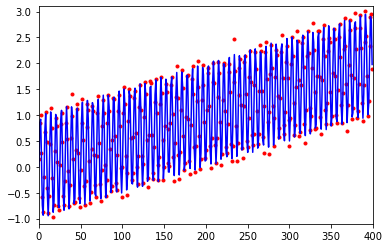

In [4]:
# sin 그래프 + 랜덤 노이즈(평균, 표준 편차, 개수)(additive noise) + 점진적 증가(gradually increasing) -> 앞에서 학습 뒤에서 테스트 하기 위해서+
data_time = np.sin(np.arange(400))+ np.random.normal(0, 0.1, 400) + np.arange(400)/200 
print(data_time.shape)
plt.plot(data_time,'r.')
plt.plot(range(400), np.sin(np.arange(400))+np.arange(400)/200, 'b')
plt.xlim(-0.5, 400.5)
plt.ylim(-1.1, 3.1)
plt.show()

In [5]:
data_matrix = []
seq_len = 3
for i in range(0, len(data_time)-seq_len):
    tmp_data = data_time[i:i+seq_len+1]
    data_matrix.append(tmp_data)

    data_matrix_np = np.array(data_matrix)
    print(data_matrix_np.shape)
    print(data_matrix_np)

(1, 4)
[[0.1456092  0.85404522 1.00597977 0.2654775 ]]
(2, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]]
(3, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]]
(4, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 [ 0.2654775  -0.58824854 -0.86658431 -0.19224974]]
(5, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 [ 0.2654775  -0.58824854 -0.86658431 -0.19224974]
 [-0.58824854 -0.86658431 -0.19224974  0.6658276 ]]
(6, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 [ 0.2654775  -0.58824854 -0.86658431 -

 [ 1.10285205  0.21431708 -0.30800944  0.04950355]]
(124, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 [ 0.2654775  -0.58824854 -0.86658431 -0.19224974]
 [-0.58824854 -0.86658431 -0.19224974  0.6658276 ]
 [-0.86658431 -0.19224974  0.6658276   1.05405363]
 [-0.19224974  0.6658276   1.05405363  0.48456497]
 [ 0.6658276   1.05405363  0.48456497 -0.4161268 ]
 [ 1.05405363  0.48456497 -0.4161268  -0.88421916]
 [ 0.48456497 -0.4161268  -0.88421916 -0.5611254 ]
 [-0.4161268  -0.88421916 -0.5611254   0.44275111]
 [-0.88421916 -0.5611254   0.44275111  1.13138037]
 [-0.5611254   0.44275111  1.13138037  0.75080871]
 [ 0.44275111  1.13138037  0.75080871 -0.20687559]
 [ 1.13138037  0.75080871 -0.20687559 -0.96028781]
 [ 0.75080871 -0.20687559 -0.96028781 -0.74456635]
 [-0.20687559 -0.96028781 -0.74456635  0.29680577]
 [-0.96028781 -0.74456635  0.29680577  0.94482537]
 [-0.74456635  0.2968

[[ 1.45609196e-01  8.54045224e-01  1.00597977e+00  2.65477497e-01]
 [ 8.54045224e-01  1.00597977e+00  2.65477497e-01 -5.88248539e-01]
 [ 1.00597977e+00  2.65477497e-01 -5.88248539e-01 -8.66584314e-01]
 [ 2.65477497e-01 -5.88248539e-01 -8.66584314e-01 -1.92249744e-01]
 [-5.88248539e-01 -8.66584314e-01 -1.92249744e-01  6.65827603e-01]
 [-8.66584314e-01 -1.92249744e-01  6.65827603e-01  1.05405363e+00]
 [-1.92249744e-01  6.65827603e-01  1.05405363e+00  4.84564974e-01]
 [ 6.65827603e-01  1.05405363e+00  4.84564974e-01 -4.16126798e-01]
 [ 1.05405363e+00  4.84564974e-01 -4.16126798e-01 -8.84219163e-01]
 [ 4.84564974e-01 -4.16126798e-01 -8.84219163e-01 -5.61125399e-01]
 [-4.16126798e-01 -8.84219163e-01 -5.61125399e-01  4.42751113e-01]
 [-8.84219163e-01 -5.61125399e-01  4.42751113e-01  1.13138037e+00]
 [-5.61125399e-01  4.42751113e-01  1.13138037e+00  7.50808712e-01]
 [ 4.42751113e-01  1.13138037e+00  7.50808712e-01 -2.06875593e-01]
 [ 1.13138037e+00  7.50808712e-01 -2.06875593e-01 -9.60287810e

(388, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 ...
 [ 2.94095207  2.29718981  1.23762285  0.88760006]
 [ 2.29718981  1.23762285  0.88760006  1.58717828]
 [ 1.23762285  0.88760006  1.58717828  2.41789168]]
(389, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 ...
 [ 2.29718981  1.23762285  0.88760006  1.58717828]
 [ 1.23762285  0.88760006  1.58717828  2.41789168]
 [ 0.88760006  1.58717828  2.41789168  3.00436689]]
(390, 4)
[[ 0.1456092   0.85404522  1.00597977  0.2654775 ]
 [ 0.85404522  1.00597977  0.2654775  -0.58824854]
 [ 1.00597977  0.2654775  -0.58824854 -0.86658431]
 ...
 [ 1.23762285  0.88760006  1.58717828  2.41789168]
 [ 0.88760006  1.58717828  2.41789168  3.00436689]
 [ 1.58717828  2.41789168  3.00436689  2.53371631]]
(391, 4)
[[ 0.1456092   0.85404522  1

In [6]:
datax = data_matrix_np[:,0:3]
datay = data_matrix_np[:,3]
print(datax.shape)
print(datay.shape)

(397, 3)
(397,)


In [8]:
trnx = datax[0:300, :]
trny = datay[0:300]
tstx = datax[300:datax.shape[0],:]
tsty = datay[300:datax.shape[0]]
print(trnx.shape)
print(tstx.shape)
print(trny.shape)
print(tsty.shape)

(300, 3)
(97, 3)
(300,)
(97,)


In [11]:
input_shape = (3,)
mlp_model = models.Sequential()
mlp_model.add(layers.Dense(units = 5, activation = 'tanh', input_shape=input_shape))
mlp_model.add(layers.Dense(units = 10, activation = 'tanh'))
mlp_model.add(layers.Dense(units = 1, activation = 'linear'))

mlp_model.compile(optimizer='Adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])

In [12]:
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 20        
                                                                 
 dense_4 (Dense)             (None, 10)                60        
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = mlp_model.fit(trnx, trny, validation_data = [tstx, tsty], batch_size = 10, epochs = 300)

Epoch 1/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.1322 - val_mean_squared_error: 0.1322
Epoch 2/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.1356 - val_mean_squared_error: 0.1356
Epoch 3/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.1456 - val_mean_squared_error: 0.1456
Epoch 4/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 5/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.1513 - val_mean_squared_error: 0.1513
Epoch 6/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Epoch 7/300
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.1473 - val_mean_squared_error: 0.1473
Epoch 52/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 53/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.1614 - val_mean_squared_error: 0.1614
Epoch 54/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.1361 - val_mean_squared_error: 0.1361
Epoch 55/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.1460 - val_mean_squared_error: 0.1460
Epoch 56/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.1106 - val_mean_squared_error: 0.1106
Epoch 57/300
30/30 [=====================

30/30 [==============================] - 0s 1ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 102/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.1310 - val_mean_squared_error: 0.1310
Epoch 103/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.1346 - val_mean_squared_error: 0.1346
Epoch 104/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.1391 - val_mean_squared_error: 0.1391
Epoch 105/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.1464 - val_mean_squared_error: 0.1464
Epoch 106/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 107/300
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.1165 - val_mean_squared_error: 0.1165
Epoch 152/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.1351 - val_mean_squared_error: 0.1351
Epoch 153/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.1379 - val_mean_squared_error: 0.1379
Epoch 154/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.1245 - val_mean_squared_error: 0.1245
Epoch 155/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 156/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.1411 - val_mean_squared_error: 0.1411
Epoch 157/300
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.1294 - val_mean_squared_error: 0.1294
Epoch 202/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 203/300
30/30 [==============================] - 0s 1ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 204/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.1047 - val_mean_squared_error: 0.1047
Epoch 205/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0995 - val_mean_squared_error: 0.0995
Epoch 206/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.1257 - val_mean_squared_error: 0.1257
Epoch 207/300
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.1261 - val_mean_squared_error: 0.1261
Epoch 252/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0843 - val_mean_squared_error: 0.0843
Epoch 253/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 254/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.1165 - val_mean_squared_error: 0.1165
Epoch 255/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.1021 - val_mean_squared_error: 0.1021
Epoch 256/300
30/30 [==============================] - 0s 2ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 257/300
30/30 [===============

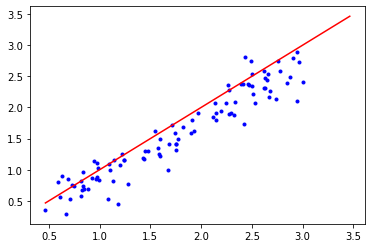

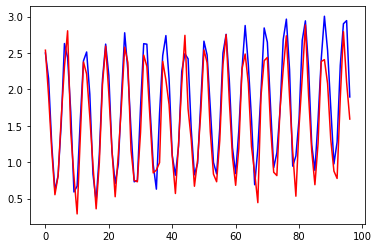

Final validation error is: 0.084627


In [29]:
plt.plot(tsty, mlp_model.predict(tstx), 'b.')
plt.plot(np.arange(min(tsty),max(tsty)+0.5),np.arange(min(tsty),max(tsty)+0.5), 'r')
plt.show()

plt.plot(range(tsty.shape[0]), tsty,'b-')
plt.plot(range(tsty.shape[0]), mlp_model.predict(tstx),'r-')
plt.show()
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

In [32]:
batch_size = 10
sequence_length = 4
data_dim = 3

In [30]:
datax = data_matrix_np[0:data_matrix_np.shape[0]-1, 0:3]
datay = data_matrix_np[0:data_matrix_np.shape[0]-1:, 3]
print(datax.shape)
print(datay.shape)


(396, 3)
(396,)


In [33]:
datax = np.reshape(datax, (-1, sequence_length, data_dim))
datay = np.reshape(datay, (-1, sequence_length, 1))
print(datax.shape)
print(datay.shape)

(99, 4, 3)
(99, 4, 1)


In [34]:
trnx = datax[0:70, :]
trny = datay[0:70]
tstx = datax[70:datax.shape[0],:]
tsty = datay[70:datax.shape[0]]
print(trnx.shape)
print(tstx.shape)
print(trny.shape)
print(tsty.shape)

(70, 4, 3)
(29, 4, 3)
(70, 4, 1)
(29, 4, 1)


In [35]:
input_shape = (datax[0].shape)
input_tensor = layers.Input(input_shape)
print(input_shape)

(4, 3)


In [37]:
rnn_layer = layers.LSTM(10, return_sequences=True)(input_tensor)
output_tensor = layers.TimeDistributed(layers.Dense(1,activation='linear'))(rnn_layer)

In [39]:
model_mtom = models.Model(input_tensor, output_tensor)
model_mtom.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

In [40]:
model_mtom.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 3)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 10)             560       
                                                                 
 time_distributed (TimeDistr  (None, 4, 1)             11        
 ibuted)                                                         
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [41]:
plt.plot(tmp, np.reshape(model_mtom.predict(tstx), (-1,1)), 'b.')
plt.plot(np.arange(min(tmp),max(tmp)+0.5), np.arange(min(tmp),max(tmp)+0.5), 'r')
plt.show()

plt.plot(range(tmp.shape[0]), tmp,'b-')
plt.plot(range(tmp.shape[0]), np.reshape(model_mtom.predict(tstx), (-1,1)),'r-')
plt.show()
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

NameError: name 'tmp' is not defined